In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.efficientnet import efficientnet_b0
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/efficientnet")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

5


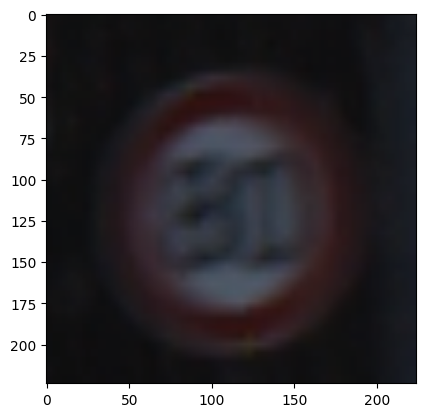

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = efficientnet_b0(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
EfficientNet                                                      --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                864
│    └─BatchNorm2d: 2-2                                           64
│    └─ReLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─InvertedResidualBlockV3: 2-4                               --
│    │    └─LinearBottleneckV3: 3-1                               2,536
│    └─InvertedResidualBlockV3: 2-5                               --
│    │    └─LinearBottleneckV3: 3-2                               9,864
│    └─InvertedResidualBlockV3: 2-6                               --
│    │    └─ResBlock: 3-3                                         19,380
│    └─InvertedResidualBlockV3: 2-7                               --
│    │    └─Linear

# training

In [13]:
epoches = 10

In [14]:
trainer = ClassificationTrainer(epoches, device)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 832/832 [06:18<00:00,  2.20it/s]


epoch 1 : 0.05292482288943855 (0%)


100%|██████████| 832/832 [02:52<00:00,  4.82it/s]


epoch 2 : 0.007196205054032572 (-86%)


100%|██████████| 832/832 [02:54<00:00,  4.76it/s]


epoch 3 : 0.0037783561432696354 (-47%)


100%|██████████| 832/832 [03:12<00:00,  4.33it/s]


epoch 4 : 0.0026374699332030525 (-30%)


100%|██████████| 832/832 [02:59<00:00,  4.63it/s]


epoch 5 : 0.0022704536754295426 (-14%)


100%|██████████| 832/832 [02:52<00:00,  4.83it/s]


epoch 6 : 0.0021144044496522315 (-7%)


100%|██████████| 832/832 [02:50<00:00,  4.88it/s]


epoch 7 : 0.0014567364255209615 (-31%)


100%|██████████| 832/832 [02:55<00:00,  4.74it/s]


epoch 8 : 0.0015964214971863665 (10%)


100%|██████████| 832/832 [03:04<00:00,  4.51it/s]


epoch 9 : 0.0013681432907874252 (-14%)


100%|██████████| 832/832 [03:09<00:00,  4.38it/s]

epoch 10 : 0.0009855930021518754 (-28%)


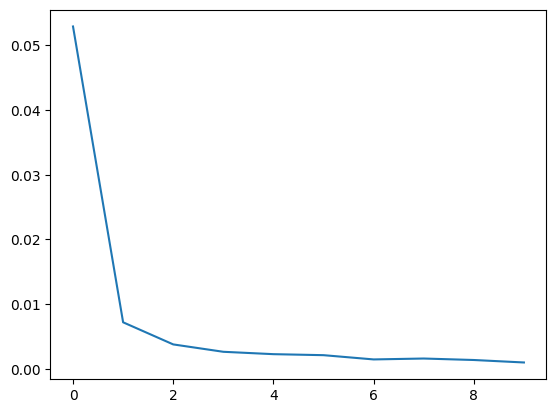

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [02:34<00:00,  2.56it/s]

[[ 60   0   0 ...   0   0   0]
 [  1 712   4 ...   0   0   0]
 [  0   1 740 ...   0   0   0]
 ...
 [  0   0   0 ...  76   0   0]
 [  0   0   0 ...   0  56   0]
 [  0   0   0 ...   0   6  56]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9888888888888889
2         : 0.9866666666666667
3         : 0.9911111111111112
4         : 0.9712121212121212
5         : 0.8555555555555555
6         : 0.92
7         : 0.98
8         : 0.9311111111111111
9         : 0.9895833333333334
10        : 0.9106060606060606
11        : 0.9952380952380953
12        : 0.9710144927536232
13        : 0.9944444444444445
14        : 0.9814814814814815
15        : 0.9857142857142858
16        : 0.9733333333333334
17        : 0.925
18        : 0.782051282051282
19        : 0.8833333333333333
20        : 0.6888888888888889
21        : 0.6555555555555556
22        : 0.75
23        : 0.9466666666666667
24        : 0.9777777777777777
25        : 0.9958333333333333
26        : 0.9555555555555556
27        : 0.85
28        : 0.9866666666666667
29        : 0.8777777777777778
30        : 0.8
31        : 0.9222222222222223
32        : 0.75
33        : 0.7238095238095238
34        : 0.8
35        : 0.9846153846153847
36        : 0

In [24]:
per_class_acc.mean()

0.8820317935724911

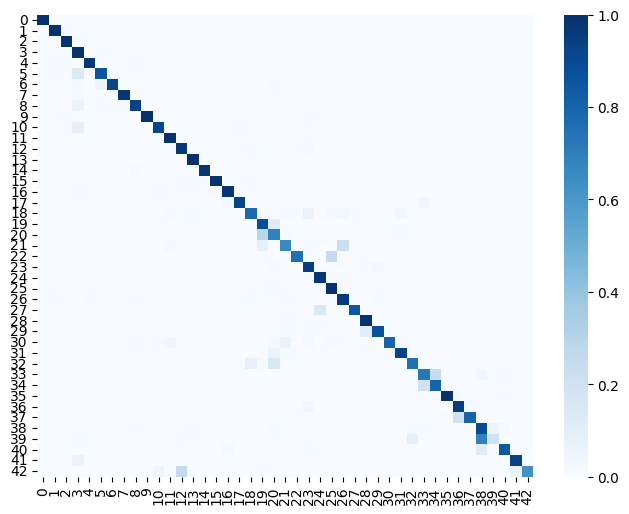

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'efficientnet.b0.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'27.76MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>